<a href="https://colab.research.google.com/github/SeongilHeo/hufs_ai_camp/blob/master/Day2_2_dnn_spiral_classification_gradienttape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 싸인 함수 회귀분석 (Sine Regression)

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) 

2.0.0


## 데이터 생성

#### Spiral Data Generation 함수 정의

In [ ]:
theta = 4

# generate the data
def generate_spiral_dataset(num_data, num_class, num_dim=2):
    input_data = np.zeros((num_data*num_class,num_dim)) # data matrix (each row = single example)
    output_data = np.zeros(num_data*num_class, dtype='uint8') # class labels

    for j in range(num_class):
      ix = range(num_data*j,num_data*(j+1))
      r = np.linspace(0.0,1,num_data) # radius [0,1]
      t = np.linspace(j*theta,(j+1)*theta,num_data) + np.random.randn(num_data)*0.2 # theta [0, 4]
      input_data[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      output_data[ix] = j
    
    return input_data, output_data

#### 훈련 데이터, 테스트 데이터 생성

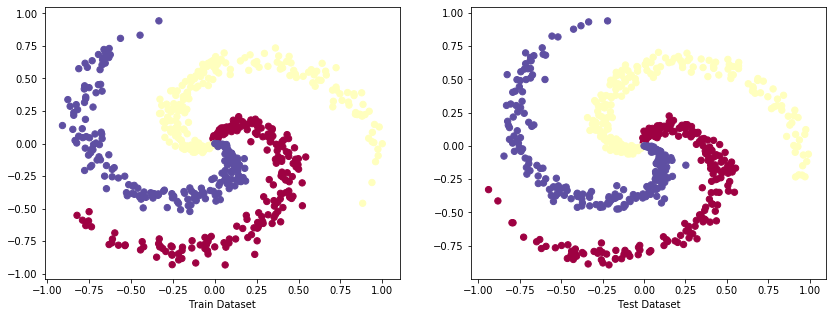

In [ ]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

train_x, train_y = generate_spiral_dataset(N, K, D)
test_x, test_y = generate_spiral_dataset(N, K, D)

# lets visualize the data:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Train Dataset")
plt.subplot(1,2,2)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.show()

## 모델 정의

In [ ]:
class Model(tf.Module):
    def __init__(self):
        # create variables
        initializer = tf.initializers.GlorotUniform()
        W0 = tf.Variable(initializer(shape=[D, 20]), dtype=tf.float32, name='W0')
        W1 = tf.Variable(initializer(shape=[20, 20]), dtype=tf.float32, name='W1')
        W2 = tf.Variable(initializer(shape=[20, K]), dtype=tf.float32, name='W2')

        b0 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b0')
        b1 = tf.Variable(tf.zeros(shape=[20]),dtype=tf.float32, name='b1')
        b2 = tf.Variable(tf.zeros(shape=[K]), dtype=tf.float32, name='b2')

        self.weights = [W0, W1, W2]
        self.biases = [b0, b1, b2]
        self.activations = [tf.nn.relu, tf.nn.relu, tf.nn.softmax]
    
    def __call__(self, x):
        layer = x
        for W, b, activation in zip(self.weights, self.biases, self.activations):
            layer = tf.matmul(layer, W) + b
            if activation is not None:
                layer = activation(layer)
        output_pred = layer
    
        return output_pred

## 모델 훈련

In [ ]:
model = Model()
optimizer = tf.optimizers.Adam() # create optimizer

# run training
batch_size = 32
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(train_x), size=batch_size)
    input_batch = tf.Variable(train_x[indices], dtype=tf.float32, name='input')
    output_batch = tf.Variable(train_y[indices], dtype=tf.uint8, name='output')
    output_batch = tf.one_hot(output_batch, K)
    
    with tf.GradientTape() as tape:
        output_pred = model(input_batch)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=output_batch, logits=output_pred)
        loss = tf.reduce_mean(loss)

        grads  = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    if training_step % 1000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss.numpy()))

0000 loss: 35.565
1000 loss: 22.661
2000 loss: 19.039
3000 loss: 17.949
4000 loss: 18.333
5000 loss: 17.662
6000 loss: 17.867
7000 loss: 17.676
8000 loss: 17.652
9000 loss: 17.649


## 테스트

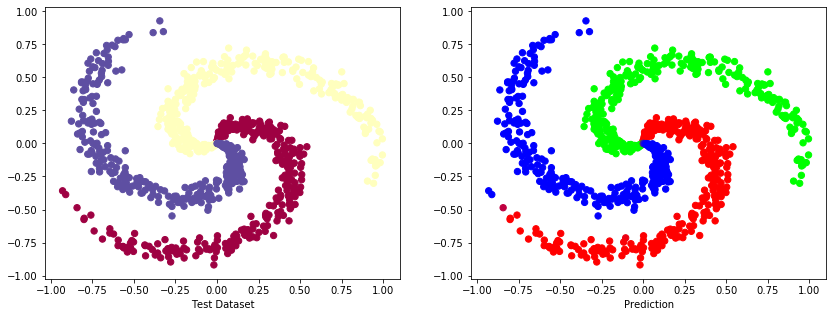

In [ ]:
test_input = tf.Variable(test_x, dtype=tf.float32, name='input')
test_output = tf.Variable(test_y, dtype=tf.float32, name='output')

test_output_pred = model(test_input)
test_output_pred = tf.nn.softmax(test_output_pred, axis=-1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_y, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.subplot(1,2,2)
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_output_pred.numpy(), s=40, cmap=plt.cm.Spectral)
plt.xlabel("Prediction")
plt.show()